**Содержание**:

1. [Теория](https://colab.research.google.com/drive/16c4XGNRZk8QDmIvK8FLGkcjQSRPY5GX4?usp=sharing)
2. Практический ноутбук

В данном ноутбуке мы решим задачу оценки зарплаты пользователя по указанным данным.

**Импортируемые модули**

In [1]:
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

E0000 00:00:1746389992.231328   40723 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746389992.258076   40723 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Парсинг (обработка) базы

Скачаем базу для работы:

In [2]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

'hh_fixed.csv'

Давайте посмотрим на данные, с которыми нам предстоит работать:

In [3]:
# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head()

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [7]:
# Пример данных

n = 0                                     # Индекс в таблице резюме
for i in range(len(df.values[n])):        # Вывод значения каждого столбца
    print('{:>2}  {}'.format(i, df.values[n][i]))

 0  Мужчина ,  29 лет , родился 16 мая 1989
 1  40000 руб.
 2  Специалист по поддержке чата(support team) домашний агент
 3  Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам
 4  полная занятость
 5  полный день
 6  Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая коммун

В представленной таблице собраны примеры резюме пользователей. Нашим целевым параметром (значением, которое должна будет предсказать нейронная сеть), будет колонка ЗП.

Остальные столбцы (за исключением двух последних) мы будем использовать как x_train, в качестве оцениваемых параметров.

Наша главная задача: **подготовить данные для подачи в сеть**. В таблице собраны данные различных типов: текстовые, числовые, категориальные. Все это нужно правильно обработать перед подачей в сеть. Для каждого столбца мы подготовим специальную функцию, которая будет парсить (обрабатывать) данные из этого столбца. В итоге мы подготовим обучающую выборку, содержащую все данные из представленной таблицы.

Прежде чем вы приступите к парсингу таблицы, рекомендуем вам ознакомится с дополнительными материалами на тему "Функциональное программирование в Keras" (ссылка ниже). Керас является гибким и мощным инструментом проектирования нейронных сетей, позволяющим создавать как линейные, так и нелинейные архитектуры:


---
Дополнительная информация ([База знаний УИИ - «**Нелинейная структура моделей Functional API**»](https://colab.research.google.com/drive/12NpGcKhCoVtuNgxdy_znoykg9NgauqMo?usp=sharing))

---





При помощи .get_loc() зафиксируйте номер столбца в определенной переменной. Это упростит обращение к столбцу и сделает код меньше и понятней:

In [8]:
# Настройка номеров столбцов
# Дальнейшие вычисления не будут зависеть от порядка столбцов в таблице

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

Теперь можем написать ряд функций для парсинга (обработки) нашей таблицы.

In [9]:
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

Функция `purify()` написана для очистки текста в таблице с данными. Она убирает из строки следующие символы:
- `\n`;
- `\xa0`;
- пробелы по краям.

А также приводит все символы к нижнему регистру.


Например:

In [10]:
text = '    Мама\xa0 мыла\nРАМУ       \xa0 '
print(f'Неочищенная строка: {text}')
print()
print(f'Обработанная строка: {purify(text)}')

Неочищенная строка:     Мама  мыла
РАМУ         

Обработанная строка: мама мыла раму


Функция `extract_year()` выделяет из строки подстроку вида ДД.ММ.ГГГГ и возвращает значение года:

In [11]:
def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

Здесь мы воспользовались конструкцией `try except` для обработки исключений. Буквально запись выше означает:
1. пробуем выполнить код:

        int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])
    
2. Если код выполняется без ошибок, то функция `extract_year()` возвращает полученное значение

3. Если код выполняется с ошибкой, то программа не вылетает и функция попадает в блок `except` и возвращает 0
  


---
Дополнительная информация ([База знаний УИИ - «**Обработка исключений (try except)**»](https://colab.research.google.com/drive/1m31BBr03P6o5F-50VBxFsdjbv-IrS51L?usp=sharing))

---





Здесь же мы воспользовались библиотекой `re` - библиотекой регулярных выражений. Более подробно об этой библиотеке можете узнать по ссылке ниже:


---
Дополнительная информация ([База знаний УИИ - «**Регулярные выражения на Python**»](https://colab.research.google.com/drive/10gyViE3w6pi6GA84roqoULjPllYE-KkK?usp=sharing))

---





In [12]:
text = 'Пётр первый родился в ночь на 30.05.1672'
print(text)
print(extract_year(text))

Пётр первый родился в ночь на 30.05.1672
1672


Следующим блоком кода вы создадите словари и списки значений для разбиения на классы

Например, список `city_class` содержит в себе словарь вида `{город: класс города}`

Списки `age_class` и `experience_class` содержат в себе пороговые значения, которые будут определять, к какому классу относить возраст или опыт человека:


In [13]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]


Как вы заметили, помимо меток классов и пороговых значений есть одно число, которое стоит на первом месте. Пока это просто нули, но следующим блоком кода вы измените их на количество различных классов

Например, для `age_class` это значение будет равно `11`, а для `city_class` – `4`.


In [14]:
# Вычисление счетчиков для данных разбиения
for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

Проверим список `age_class`:

In [15]:
age_class

[11, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

Как видите, теперь первым элементов стоит число `11` - количество категорий

Функция `int_to_ohe()` возвращает one hot encoding представление значения класса.

Что это значит?

Если количество классов равно 5, то one hot представление для класса `0` будет: `[1, 0, 0, 0, 0]`.

А, например, для класса 3 - `[0, 0, 0, 1, 0]`

In [16]:
def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [19]:
age = 32
int_to_ohe(age, age_class)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

Функция `str_to_multi()` сопоставляет строковому значению метку класса.

Функционально это то же самое, что и предыдущий случай, но для `city_class`, `employment_class` и т. д.


In [20]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [21]:
text = 'полная занятость'
print(text)
print(str_to_multi(text, employment_class))

полная занятость
[0. 0. 0. 1.]


Функция `extract_sex_age_years()` выделяет из строки информацию про пол и возраст человека:

In [22]:
base_update_year = 2019

In [23]:
# Разбор значений пола, возраста

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [24]:
text = 'мужчина , 33 года , родился 2 августа 1985'
print(text)
print(extract_sex_age_years(text))

мужчина , 33 года , родился 2 августа 1985
(1.0, 34)


Функция `age_years_to_ohe()` просто использует функцию `int_to_ohe()`, передавая ей список `age_class`:

In [25]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [26]:
print(age_years_to_ohe(32))

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Функция `experience_months_to_ohe()` работает точно так же, только передает `experience_class`:

In [27]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [28]:
print(experience_months_to_ohe(100))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Функция `extract_salary()` выделяет из строки значение зарплаты и переводит его в курс рубля.

Значение возвращается в тыс. рублей:

In [29]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [30]:
print(extract_salary('40000 руб.'))
print(extract_salary('40000 eur.'))

40.0
2800.0


Функция `extract_city_to_ohe()` выделяет из строки название города, основываясь на `city_class` и переводит значение класса в one hot encoding:

In [31]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [32]:
print(extract_city_to_ohe('москва , м. юго-западная , не готов к переезду'))

[1. 0. 0. 0.]


Функции `extract_employment_to_multi()`, `extract_schedule_to_multi()`, `extract_education_to_multi()` используют функцию `str_to_multi()`, передавая ей соответствующие данные:

In [33]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [34]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [35]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.

    return result

In [36]:
print(extract_employment_to_multi('полная занятость'))
print(extract_schedule_to_multi('полный день'))
print(extract_education_to_multi('высшее образование 2011'))


[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]


Функция `extract_experience_months()` выделяет из текста информацию об опыте работы в месяцах:

In [37]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

In [38]:
print(extract_experience_months('опыт работы 3 года 9 месяцев'))

45


**Функции подготовки выборок**

Теперь мы готовы создать выборки с помощью подготовленных выше функций:

In [39]:
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [40]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

Функция `construct_train_data()` осуществляет проходи по каждой строке исходного датафрейма, передавая эту строку в функцию `extract_row_data()`.

Функция `extract_row_data()` для каждой ячейки вызывает соответствующую функцию (из рассмотренных выше)

В итоге мы получаем следующие наборы данных:

In [41]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


**Функция отрисовки графика истории обучения**

In [42]:
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

## Обучение модели на числовых данных:

Создадим и обучим нейронную сеть, обрабатывающую сформированную выборку:

/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1746397214.601290   40723 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


I0000 00:00:1746397216.585477   75192 service.cc:148] XLA service 0x7f0e400046c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746397216.586195   75192 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1746397216.765953   75192 cuda_dnn.cc:529] Loaded cuDNN version 90300


 63/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10867.0781 - mae: 77.2068

I0000 00:00:1746397223.157791   75192 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 11042.1699 - mae: 76.8587 - val_loss: 11918.8643 - val_mae: 79.6010
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10579.8311 - mae: 73.7002 - val_loss: 11035.8818 - val_mae: 74.0743
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9799.2480 - mae: 67.9501 - val_loss: 9831.1738 - val_mae: 66.1282
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8327.8086 - mae: 59.2858 - val_loss: 8504.8496 - val_mae: 57.3233
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7193.6021 - mae: 51.4332 - val_loss: 7293.6084 - val_mae: 50.1657
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6222.3159 - mae: 45.3364 - val_loss: 6402.9136 - val_mae: 46.3416
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5849.2275 - mae: 42.9967 - val_loss: 5872.0747 - val_mae: 45.3775
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5356.0342 - mae: 43.2745 - val_loss: 5600.4727 - val_mae: 45.61

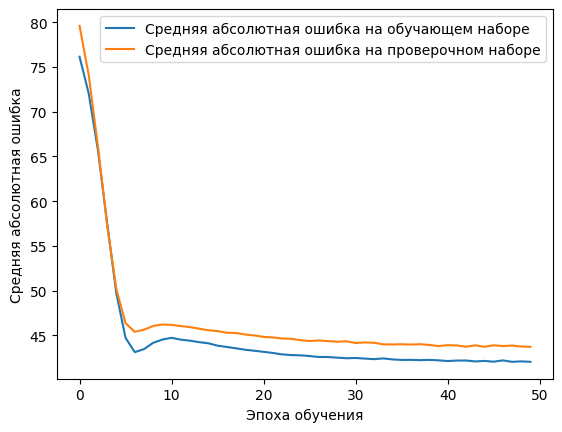

In [43]:
# Обучение модели на простых данных

model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x_train_01.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model_simple.fit(x_train_01,
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Как оценить работу сети?**

In [44]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple.predict(x_train_01)

# Расчет среднего значения ошибки
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
42.30807445586856
42.30807445586856


Полученные значения буквально означают, что наша модель ошибается в среднем на 42 тысячи рублей. Скажем честно, хотелось бы видеть показатели получше.

Прежде чем двинемся дальше, напишем функцию, которая показывает разбор между реальными и предсказанными значениями:

In [45]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

Функция eval_net производит оценку результатов работы нейронной сети:
 - метод predict принимает на вход данные, по которым нужно сделать предсказания
 - дальше производим денормировку предсказаний, если необходимо
 - считаем среднюю абсолютную ошибку
 - строим точечный график зависимости предсказаний от верных ответов

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Средняя абсолютная ошибка: 42.30807445586856 

Реальное значение:  40.00  Предсказанное значение:  64.33  Разница:  24.33
Реальное значение:  40.00  Предсказанное значение:  93.24  Разница:  53.24
Реальное значение: 300.00  Предсказанное значение:  96.71  Разница: 203.29
Реальное значение: 180.00  Предсказанное значение: 103.47  Разница:  76.53
Реальное значение:  40.00  Предсказанное значение:  32.99  Разница:   7.01
Реальное значение: 200.00  Предсказанное значение:  96.71  Разница: 103.29
Реальное значение: 120.00  Предсказанное значение: 111.67  Разница:   8.33
Реальное значение:  50.00  Предсказанное значение:  81.58  Разница:  31.58
Реальное значение:  60.00  Предсказанное значение:  68.24  Разница:   8.24
Реальное значение:  70.00  Предсказанное значение:  76.30  Разница:   6.30


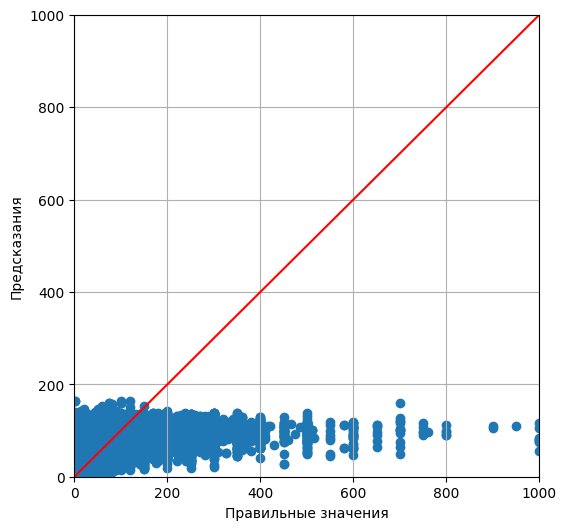

In [46]:
eval_net(model_simple, x_train_01, y_train)

В идеале значения на графике должны располагаться вдоль красной диагональной линии

## Нормализация данных зарплаты

На следующем шаге мы нормализуем значение зарплаты, которое предсказывает нейронная сеть

In [47]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

Воспользуемся для этого стандартным инструментом библиотеки `sklearn` - `StandardScaler`'ом, с помощью которого сможем преобразовать наши данные к нормальному распределению

In [48]:
# Проверка нормализации
print(y_train_scaled.shape)
print(f'Оригинальное значение зарплаты:  {y_train[1, 0]}')
print(f'Нормированное значение зарплаты: {y_train_scaled[1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(y_train.mean(), y_train.std())
print(y_train_scaled.mean(), y_train_scaled.std())

(62967, 1)
Оригинальное значение зарплаты:  40.0
Нормированное значение зарплаты: -0.5247285785360603
77.9847331935776 72.3892975289266
-1.2457941148207006e-16 0.9999999999999998


Мы нормировали значения зарплат в нашем наборе данных. В итоге полученный массив `y_train_scaled` обладает следующими характеристиками:
- среднее значение массива практически равно 0
- среднеквадратичное отклонение практически равно 1

Подобные значения, как показывает практика, значительно лучше анализируются нейронными сетями. Проверим это на нашей задаче:


Epoch 1/50


/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0226 - mae: 0.6019 - val_loss: 0.9832 - val_mae: 0.6261
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8346 - mae: 0.5866 - val_loss: 0.9494 - val_mae: 0.6091
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8675 - mae: 0.5835 - val_loss: 0.9423 - val_mae: 0.5998
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8728 - mae: 0.5804 - val_loss: 0.9370 - val_mae: 0.6042
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9766 - mae: 0.5893 - val_loss: 0.9364 - val_mae: 0.5990
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8760 - mae: 0.5837 - val_loss: 0.9345 - val_mae: 0.6024
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8338 - mae: 0.5758 - val_loss: 0.9349 - val_mae: 0.5964
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8853 - mae: 0.5758 - val_loss: 0.9334 - val_mae: 0.5994
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8988

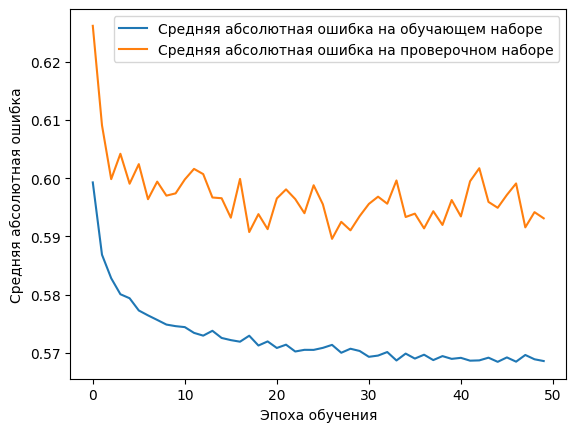

In [49]:
# Обучение модели на простых данных с нормализованной зарплатой
model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x_train_01.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model_simple.fit(x_train_01,
                    y_train_scaled,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Оценка результатов**


1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Средняя абсолютная ошибка: 41.26565954006956 

Реальное значение:  40.00  Предсказанное значение:  61.28  Разница:  21.28
Реальное значение:  40.00  Предсказанное значение:  90.77  Разница:  50.77
Реальное значение: 300.00  Предсказанное значение:  92.81  Разница: 207.19
Реальное значение: 180.00  Предсказанное значение:  92.18  Разница:  87.82
Реальное значение:  40.00  Предсказанное значение:  35.33  Разница:   4.67
Реальное значение: 200.00  Предсказанное значение:  92.81  Разница: 107.19
Реальное значение: 120.00  Предсказанное значение: 114.66  Разница:   5.34
Реальное значение:  50.00  Предсказанное значение:  60.34  Разница:  10.34
Реальное значение:  60.00  Предсказанное значение:  46.51  Разница:  13.49
Реальное значение:  70.00  Предсказанное значение:  77.05  Разница:   7.05


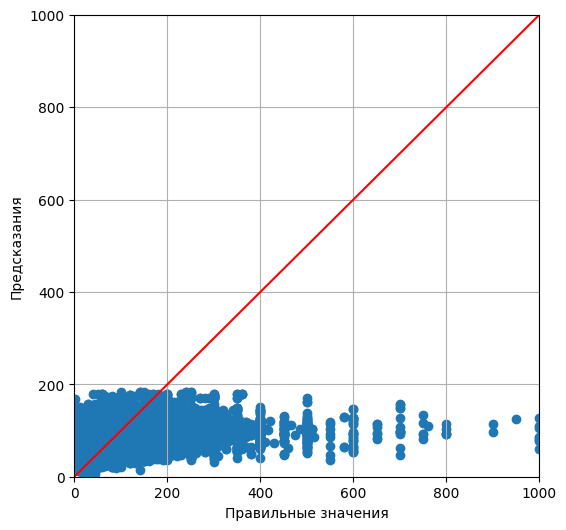

In [50]:
eval_net(model_simple, x_train_01, y_train, y_scaler)

Полученное значение ошибки немного лучше предыдущего 40 тысяч против 42.

Поэтому мы продолжаем наши эксперименты и создадим обучающий набор на основе текстовых данных нашей исходной таблицы

## Подготовка текстовых данных "Должность"

Вначале соберем обучающий набор на основе столбцов с текущей и желаемой должностью:

In [51]:
# Функция извлечения данных о профессии

def extract_prof_text(row_list):
    result = []

    # Для всех строк таблицы: собрать значения
    # столбцов желаемой и прошлой должности
    # если есть информация о зарплате

    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_POS_SEEK]) + ' ' + str(row[COL_POS_PREV]))

    # Возврат в виде массива
    return result

In [52]:
# Извлечение текстов о профессии для выборки
prof_text = extract_prof_text(df.values)

# Пример текста о профессии из резюме
print(df.values[120])
print(prof_text[120])

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [53]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

tokenizer.fit_on_texts(prof_text)

In [54]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('инженер', 2), ('специалист', 3), ('по', 4), ('менеджер', 5), ('администратор', 6), ('руководитель', 7), ('системный', 8), ('отдела', 9), ('программист', 10), ('ведущий', 11), ('проектов', 12), ('разработчик', 13), ('it', 14), ('поддержки', 15), ('аналитик', 16), ('и', 17), ('технической', 18), ('проекта', 19), ('начальник', 20), ('ит', 21), ('директор', 22), ('интернет', 23), ('с', 24), ('главный', 25), ('старший', 26), ('оператор', 27), ('продажам', 28), ('работе', 29), ('технический', 30), ('монтажник', 31), ('систем', 32), ('developer', 33), ('web', 34), ('связи', 35), ('клиентами', 36), ('информационных', 37), ('консультант', 38), ('группы', 39), ('1с', 40), ('технологий', 41), ('заместитель', 42), ('manager', 43), ('техник', 44), ('дизайнер', 45), ('помощник', 46), ('службы', 47), ('магазина', 48), ('сервисный', 49), ('маркетолог', 50)]
Размер словаря 10025


In [55]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
prof_seq = tokenizer.texts_to_sequences(prof_text)

**Создание обучающей и проверочной выборок**


In [56]:
# Преобразование последовательностей индексов в bag of words
x_train_prof_01 = tokenizer.sequences_to_matrix(prof_seq)

In [57]:
# Проверка результата
print(x_train_prof_01.shape)

(62967, 3000)


In [58]:
# Проверка получившихся данных
n = 0
print(prof_text[n])                       # Профессия в тексте
print(prof_seq[n])                        # Профессия в индексах слов
print(x_train_prof_01[n][0:100])          # Профессия в bag of words

Специалист по поддержке чата(support team) домашний агент Генеральный директор
[3, 4, 130, 987, 235, 114, 1, 346, 168, 22]
[0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [59]:
# Освобождение памяти от ненужных более объектов
del prof_text, prof_seq, tokenizer

Мы подготовили выборку на основе текстовых данных о должности пользователя. Попробуем обучить нейронную сеть на основе собранных данных

**Обучение модели на простых текстовых данных**


/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.0125 - mae: 0.6436 - val_loss: 1.0636 - val_mae: 0.6596
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9676 - mae: 0.6389 - val_loss: 1.0549 - val_mae: 0.6552
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9500 - mae: 0.6325 - val_loss: 1.0424 - val_mae: 0.6490
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9106 - mae: 0.6255 - val_loss: 1.0262 - val_mae: 0.6407
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9126 - mae: 0.6126 - val_loss: 1.0066 - val_mae: 0.6305
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9128 - mae: 0.6088 - val_loss: 0.9845 - val_mae: 0.6188
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9133 - mae: 0.5934 - val_loss: 0.9610 - val_mae: 0.6066
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9343 - mae: 0.5854 - val_loss: 0.9371 - val_mae: 0.5947
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

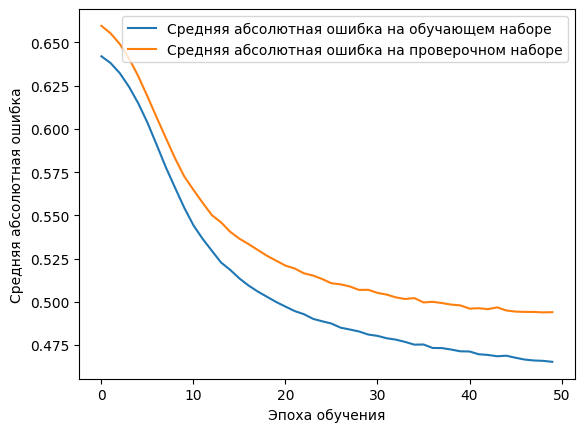

In [60]:
# Обучение модели на данных о профессии

model_prof = Sequential()
model_prof.add(Dense(20, activation='relu', input_dim=x_train_prof_01.shape[1]))
model_prof.add(Dense(500, activation='relu'))
model_prof.add(Dense(1, activation='linear'))

model_prof.compile(optimizer=Adagrad(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_prof.fit(x_train_prof_01,
                    y_train_scaled,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Оценка результатов**


1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Средняя абсолютная ошибка: 34.05329951103802 

Реальное значение:  40.00  Предсказанное значение: 118.11  Разница:  78.11
Реальное значение:  40.00  Предсказанное значение:  54.88  Разница:  14.88
Реальное значение: 300.00  Предсказанное значение: 212.64  Разница:  87.36
Реальное значение: 180.00  Предсказанное значение: 109.53  Разница:  70.47
Реальное значение:  40.00  Предсказанное значение:  63.74  Разница:  23.74
Реальное значение: 200.00  Предсказанное значение: 233.85  Разница:  33.85
Реальное значение: 120.00  Предсказанное значение:  70.37  Разница:  49.63
Реальное значение:  50.00  Предсказанное значение:  31.39  Разница:  18.61
Реальное значение:  60.00  Предсказанное значение:  79.42  Разница:  19.42
Реальное значение:  70.00  Предсказанное значение:  42.73  Разница:  27.27


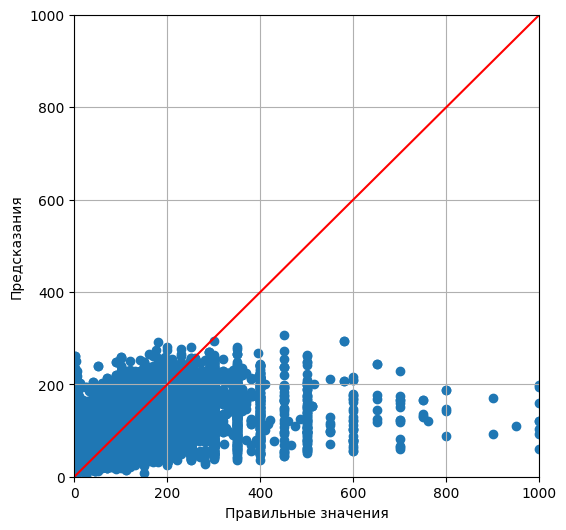

In [61]:
eval_net(model_prof, x_train_prof_01, y_train, y_scaler)

Мы получили лучшее на данный момент значение ошибки: 33 тыс. руб

И это только на основе одних лищь текстовых данных о должности.

В нашей исходной таблице было еще одно текстовой поле - это информация об опыте работы. На следующем шаге мы сформируем выборку на основе этих данных

## Подготовка текстовых данных "Опыт работы"

In [62]:
# Функция извлечения данных описания опыта работы

def extract_exp_text(row_list):
    result = []

    # Для всех строк таблицы: собрать значения опыта работы,
    # если есть информация о зарплате
    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_EXP]))

    # Возврат в виде массива
    return result

In [63]:
# Извлечение текстов об опыте работы для выборки
exp_text = extract_exp_text(df.values)

# Пример текста об опыте работы из резюме
print(df.values[120])
print(exp_text[120])

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [64]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Построение частотного словаря по текстам профессий
tokenizer.fit_on_texts(exp_text)

In [65]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 124327), ('и', 2), ('в', 3), ('по', 4), ('с', 5), ('на', 6), ('работы', 7), ('месяцев', 8), ('•', 9), ('для', 10), ('1', 11), ('разработка', 12), ('ru', 13), ('интернет', 14), ('2', 15), ('работа', 16), ('опыт', 17), ('года', 18), ('интеграция', 19), ('месяца', 20), ('3', 21), ('москва', 22), ('системная', 23), ('технологии', 24), ('www', 25), ('время', 26), ('системы', 27), ('год', 28), ('лет', 29), ('контроль', 30), ('настройка', 31), ('ооо', 32), ('информационные', 33), ('оборудования', 34), ('компании', 35), ('4', 36), ('5', 37), ('бизнес', 38), ('7', 39), ('поддержка', 40), ('организация', 41), ('2018', 42), ('сети', 43), ('ит', 44), ('8', 45), ('администрирование', 46), ('2017', 47), ('данных', 48), ('систем', 49), ('инженер', 50)]
Размер словаря 325174


In [66]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
exp_seq = tokenizer.texts_to_sequences(exp_text)

**Создание обучающей и проверочной выборок**

In [67]:
# Преобразование последовательностей индексов в bag of words
x_train_exp_01 = tokenizer.sequences_to_matrix(exp_seq)

In [68]:
# Проверка результата
print(x_train_exp_01.shape)
print(x_train_exp_01[0][0:100])

(62967, 3000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [69]:
# Проверка получившихся данных
n = 0
print(exp_text[n])                       # Опыт работы в тексте
print(exp_seq[n])                        # Опыт работы в индексах слов
print(x_train_exp_01[n][0:100])          # Опыт работы в bag of words

Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая коммуникация Пользователь ПК Ведение переговоров Управление персоналом Деловая переписка Составление договоров Телефонные переговоры Грамотная речь MS Outlook Водительское удостоверение категории B Работа в команде Возникли неполадки. Попробуйте еще 

In [70]:
# Освобождение памяти от ненужных более объектов
del exp_text, exp_seq, tokenizer

**Обучение модели**


/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.6249 - mae: 0.4691 - val_loss: 0.5325 - val_mae: 0.4216
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4388 - mae: 0.3618 - val_loss: 0.4986 - val_mae: 0.3995
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3252 - mae: 0.3279 - val_loss: 0.4890 - val_mae: 0.3754
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2088 - mae: 0.2861 - val_loss: 0.4843 - val_mae: 0.3703
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1733 - mae: 0.2661 - val_loss: 0.4695 - val_mae: 0.3576
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1397 - mae: 0.2417 - val_loss: 0.4674 - val_mae: 0.3515
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1497 - mae: 0.2336 - val_loss: 0.4649 - val_mae: 0.3588
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0956 - mae: 0.2086 - val_loss: 0.4466 - val_mae: 0.3360
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

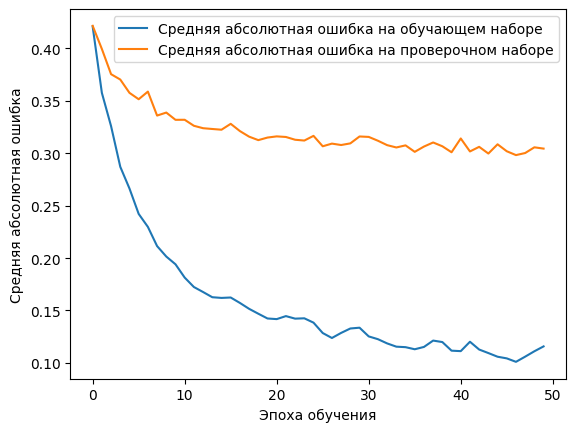

In [71]:
# Обучение модели на данных об опыте работы (должности)

model_exp = Sequential()
model_exp.add(Dense(30, activation='relu', input_dim=x_train_exp_01.shape[1]))
model_exp.add(Dense(800, activation='relu'))
model_exp.add(Dropout(0.3))
model_exp.add(Dense(1, activation='linear'))

model_exp.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])

history = model_exp.fit(x_train_exp_01,
                    y_train_scaled,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

**Оценка результатов**


1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Средняя абсолютная ошибка: 9.509405192303461 

Реальное значение:  40.00  Предсказанное значение:  49.30  Разница:   9.30
Реальное значение:  40.00  Предсказанное значение:  30.46  Разница:   9.54
Реальное значение: 300.00  Предсказанное значение: 301.81  Разница:   1.81
Реальное значение: 180.00  Предсказанное значение: 158.69  Разница:  21.31
Реальное значение:  40.00  Предсказанное значение:  27.88  Разница:  12.12
Реальное значение: 200.00  Предсказанное значение: 182.94  Разница:  17.06
Реальное значение: 120.00  Предсказанное значение: 101.88  Разница:  18.12
Реальное значение:  50.00  Предсказанное значение:  38.61  Разница:  11.39
Реальное значение:  60.00  Предсказанное значение:  42.77  Разница:  17.23
Реальное значение:  70.00  Предсказанное значение:  56.95  Разница:  13.05


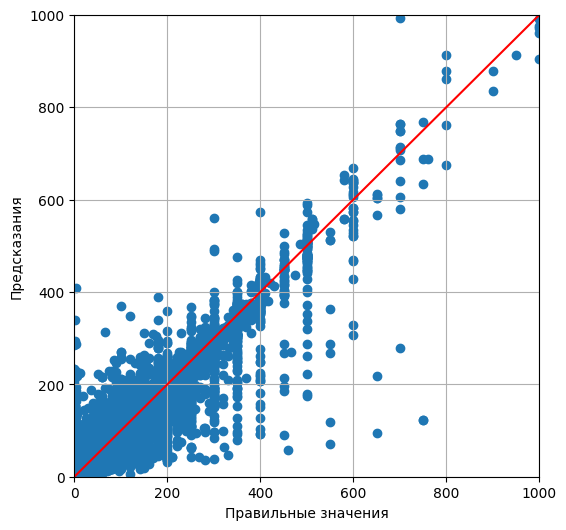

In [72]:
eval_net(model_exp, x_train_exp_01, y_train, y_scaler)

In [73]:
# Освобождение памяти
del model_simple, model_prof, model_exp

И это самый лучший результат. Очень хорошая цифра: 9 тыс. руб

В финальной части мы создадим обещанную сложную нелинейную архитектуру нейронной сети. Мы создадим модель, у которой будет три входных набора данных:

- числовой набор (это наша первая выборка)
- текстовый набор (набор, содержащий информацию о должностях)
- текстовый набор (набор, содержащий информацию об опыте работы)

## Обучение нейронной сети класса Model

In [74]:
input1 = Input((x_train_01.shape[1],))
input2 = Input((x_train_prof_01.shape[1],))
input3 = Input((x_train_exp_01.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x3 = input3                               # Ветка 3
x3 = Dense(30, activation="relu")(x3)
x3 = Dense(800, activation="relu")(x3)
x3 = Dropout(0.3)(x3)

x = concatenate([x1, x2, x3])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2, input3), x)

Практическое отличие от модели Sequential в том, что мы определяем слои как переменные, и у каждого слоя указан его вход, то есть откуда ему приходят на вход данные, таким образом:

    x1 = input1                               
    x1 = Dense(128, activation="relu")(x1) #(x1) - то, откуда придут данные на полносвязный слой

Далее необходимо создать нашу нейронную сеть из класса Model. В качестве параметров нужно передать нейронные слои/слой, котрые являются входами сети, и нейронные слои/слой выхода сети.

    model_final = Model((input1, input2, input3), x)

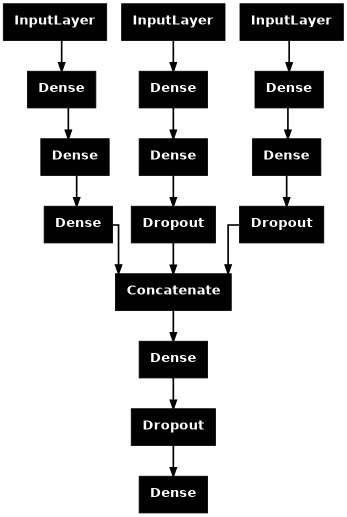

In [75]:
utils.plot_model(model_final, dpi=60)

Вот так выглядит структура созданной нейронной сети

Остальные шаги выполняются практически так же как и для последовательной модели. В методе fit в качестве обучающих данных нужно передать спискок из наборов данных для каждого входа нейронной сети.

In [76]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([x_train_01, x_train_prof_01, x_train_exp_01],
                           y_train_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.6837 - mae: 0.4845 - val_loss: 0.5086 - val_mae: 0.3991
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4703 - mae: 0.3985 - val_loss: 0.4783 - val_mae: 0.3794
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3607 - mae: 0.3604 - val_loss: 0.4793 - val_mae: 0.3780
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3071 - mae: 0.3442 - val_loss: 0.4572 - val_mae: 0.3683
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3130 - mae: 0.3437 - val_loss: 0.4404 - val_mae: 0.3538
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2955 - mae: 0.3302 - val_loss: 0.4465 - val_mae: 0.3474
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2499 - mae: 0.3139 - val_loss: 0.4320 - val_mae: 0.3558
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2308 - mae: 0.3061 - val_loss: 0.4197 - val_mae: 0.3436
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

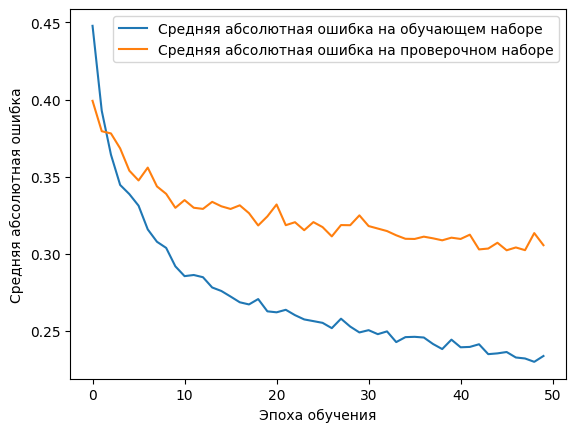

In [77]:
plot_history(history)

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Средняя абсолютная ошибка: 12.65852992809629 

Реальное значение:  40.00  Предсказанное значение:  41.75  Разница:   1.75
Реальное значение:  40.00  Предсказанное значение:  55.69  Разница:  15.69
Реальное значение: 300.00  Предсказанное значение: 305.40  Разница:   5.40
Реальное значение: 180.00  Предсказанное значение: 146.88  Разница:  33.12
Реальное значение:  40.00  Предсказанное значение:  40.44  Разница:   0.44
Реальное значение: 200.00  Предсказанное значение: 174.25  Разница:  25.75
Реальное значение: 120.00  Предсказанное значение: 116.82  Разница:   3.18
Реальное значение:  50.00  Предсказанное значение:  47.08  Разница:   2.92
Реальное значение:  60.00  Предсказанное значение:  65.70  Разница:   5.70
Реальное значение:  70.00  Предсказанное значение:  64.79  Разница:   5.21


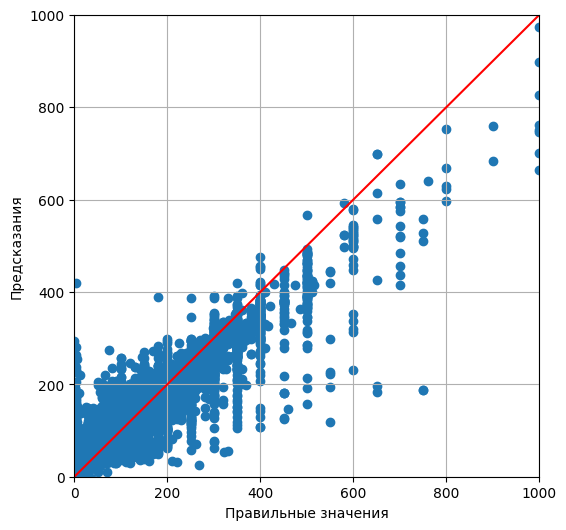

In [78]:
eval_net(model_final, [x_train_01, x_train_prof_01, x_train_exp_01], y_train, y_scaler)

**Вывод**

Мы провели несколько экспериментов с имеющимися данными. Получили две модели, дающие довольно хороший результат:
- линейная модель на основе анализа опыта работы (Ошибка: 9 тыс. руб)
- нелинейная модель на основе анализа всех имеющихся данных (Ошибка: 13 тыс. руб)

Дальнейшая работа по улучшению показателей может вестись с двумя последними архитектурами


**Содержание**:

1. [Теория](https://colab.research.google.com/drive/16c4XGNRZk8QDmIvK8FLGkcjQSRPY5GX4?usp=sharing)
2. Практический ноутбук